# Analyze Translation Scores

This notebook analyze translations scores using mutliple reference-free metrics

The scores must be already computed using the `run_translation_quality.py` script.

In [ ]:
import typing

from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from .utils.datasets import read_dataset


pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 150)

In [ ]:
OUTPUT_PATH = Path("..") / "outputs"

dataset_dir = "BeaverTails-it"
model_dir = "nllb-200-3.3B"
# model_dir = "X-ALMA-13B-Group2"
# model_dir = "TowerInstruct-Mistral-7B-v0.2"
split_dir = ["330k_test", "330k_train"]

scores_data_path = OUTPUT_PATH / dataset_dir / model_dir
dataset = read_dataset(scores_data_path, split_dir, include_scores=True)
df = typing.cast(pd.DataFrame, dataset.to_pandas())

Generating train split: 0 examples [00:00, ? examples/s]

In [12]:
text_cols = ["prompt", "prompt_it", "response", "response_it", "category"]
score_cols = ["wmt22-cometkiwi-da", "wmt23-cometkiwi-da-xl", "wmt23-cometkiwi-da-xxl", "XCOMET-XXL"]

for field in text_cols:
    df[field] = df[field].astype("string")

In [ ]:
n_samples = len(df)
print(f"Samples: {n_samples}\n")

# completely equal rows
df = df.drop_duplicates()
print(f"Removed {n_samples - len(df)} duplicates, Samples: {len(df)}")

Samples: 333963

Removed 146636 duplicates, Samples: 187327


In [ ]:
# split prompt and responses fields in two dataframes
prompt_df = df[[c for c in df.columns if c.startswith("prompt")]].copy()
response_df = df[[c for c in df.columns if c.startswith("response")]].copy()

# rename columns
prompt_df.columns = prompt_df.columns.str.replace("prompt_", "", regex=False)
prompt_df = prompt_df.rename(columns={"prompt": "en"})
response_df.columns = response_df.columns.str.replace("response_", "", regex=False)
response_df = response_df.rename(columns={"response": "en"})

# round scores to remove duplicated scores
prompt_df_tmp = prompt_df.copy()
response_df_tmp = response_df.copy()

prompt_df_tmp[score_cols] = prompt_df_tmp[score_cols].round(2)
response_df_tmp[score_cols] = response_df_tmp[score_cols].round(2)

prompt_dups = prompt_df_tmp.duplicated(keep="first")
response_dups = response_df_tmp.duplicated(keep="first")

unique_prompt_df = prompt_df[~prompt_dups]
unique_response_df = response_df[~response_dups]

assert unique_prompt_df.duplicated(["en", "it"]).sum() == 0  # noqa: S101
assert unique_response_df.duplicated(["en", "it"]).sum() == 0  # noqa: S101

print(f"Unique Prompts: {len(unique_prompt_df)}\nUnique Responses: {len(unique_response_df)}")

Unique Prompts: 16195
Unique Responses: 110401


## Compare Quality Models

In [15]:
print("\nPrompts:")
display(unique_prompt_df.describe())

print("\nResponses:")
display(unique_response_df.describe())


Prompts:


,wmt22-cometkiwi-da,wmt23-cometkiwi-da-xl,wmt23-cometkiwi-da-xxl,XCOMET-XXL
count,16195.000000,16195.000000,16195.000000,16195.000000
mean,0.834247,0.724597,0.796752,0.921268
std,0.099514,0.192934,0.232275,0.146387
min,0.231485,-0.107819,-0.029776,0.019076
25%,0.829174,0.642589,0.707344,0.917605
50%,0.878400,0.797277,0.909193,0.978873
75%,0.891351,0.862867,0.963721,1.000000
max,0.914726,0.995478,1.001839,1.000000



Responses:


,wmt22-cometkiwi-da,wmt23-cometkiwi-da-xl,wmt23-cometkiwi-da-xxl,XCOMET-XXL
count,110401.000000,110401.000000,110401.000000,110401.000000
mean,0.811501,0.691025,0.752848,0.825784
std,0.109837,0.202457,0.238711,0.194896
min,0.144352,-0.169116,-0.042708,-0.052993
25%,0.772057,0.595584,0.634319,0.756741
50%,0.863396,0.770909,0.855190,0.892262
75%,0.886309,0.836823,0.928984,0.967094
max,0.914438,1.007997,0.999276,1.000000


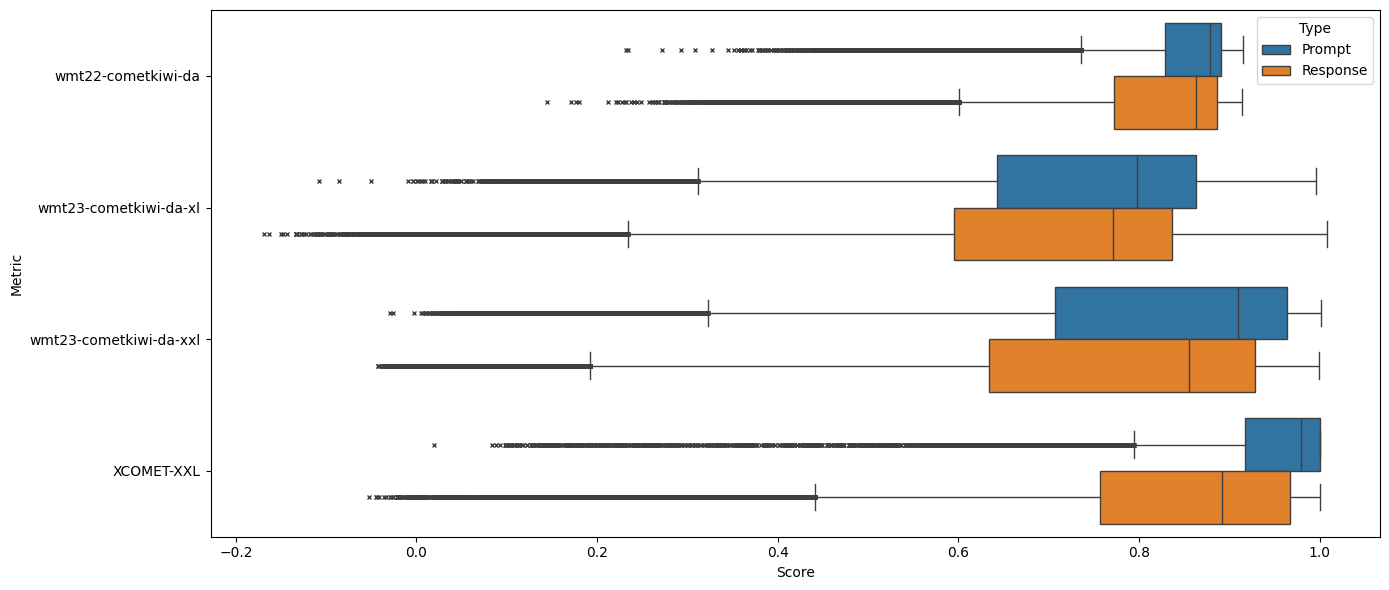

In [ ]:
# Compare the scores of quality metrics

unique_prompt_df = unique_prompt_df.copy()
unique_response_df = unique_response_df.copy()

unique_prompt_df.loc[:, "Type"] = "Prompt"
unique_response_df.loc[:, "Type"] = "Response"

combined_df = pd.concat([unique_prompt_df, unique_response_df], ignore_index=True)
combined_melt = combined_df[[*score_cols, "Type"]].melt(var_name="Metric", value_name="Score", id_vars=["Type"])

fig = plt.figure(figsize=(14, 6))

sns.boxplot(y="Metric", x="Score", hue="Type", data=combined_melt, fliersize=3.0, flierprops={"marker": "x"})

plt.tight_layout()
plt.show()

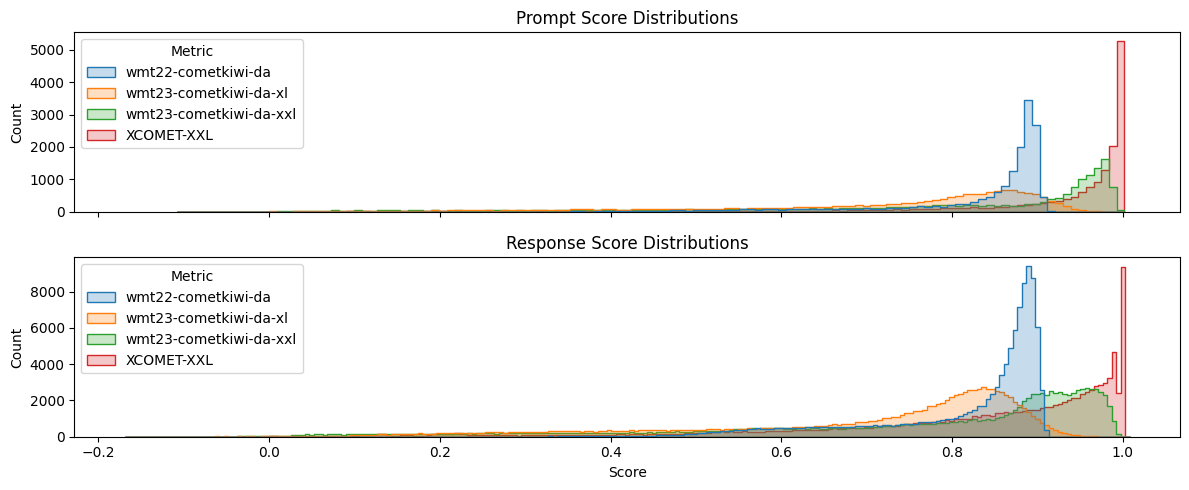

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

prompt_melt = combined_melt[combined_melt["Type"] == "Prompt"]
response_melt = combined_melt[combined_melt["Type"] == "Response"]

sns.histplot(data=prompt_melt, x='Score', hue="Metric", stat="count", element="step", ax=axes[0])
axes[0].set_title('Prompt Score Distributions')
axes[0].set_xlabel('Score')

sns.histplot(data=response_melt, x='Score', hue="Metric", stat="count", element="step", ax=axes[1])
axes[1].set_title('Response Score Distributions')
axes[1].set_xlabel('Score')

plt.tight_layout()
plt.show()

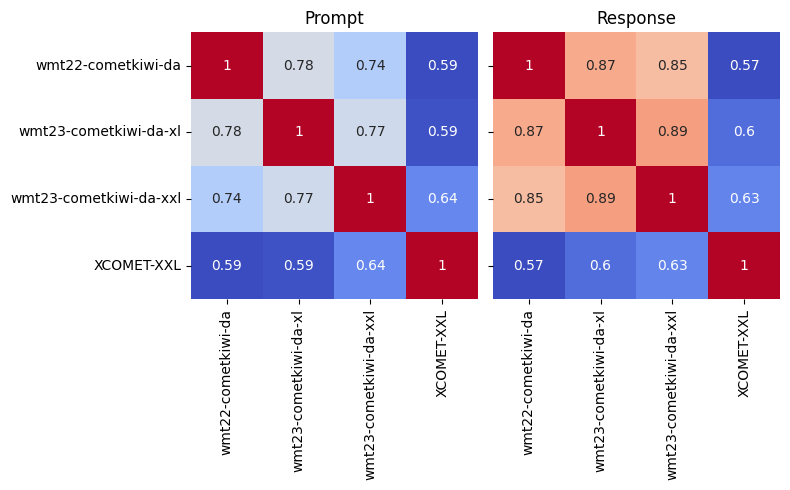

In [19]:
# Plot the correlation between quality models

fig, axes = plt.subplots(1, 2, figsize=(8, 5), sharex="all", sharey="all")
cm = unique_prompt_df[score_cols].corr()
sns.heatmap(cm, annot=True, cmap='coolwarm', cbar=False, ax=axes[0])
axes[0].set_title("Prompt")

cm = unique_response_df[score_cols].corr()
sns.heatmap(cm, annot=True, cmap='coolwarm', cbar=False, ax=axes[1])
axes[1].set_title("Response")

plt.tight_layout()
plt.show()

## Bad Translations

In [20]:
p_ge05 = prompt_df[score_cols].ge(0.5).all(axis=1).mean()
r_ge05 = response_df[score_cols].ge(0.5).all(axis=1).mean()

p_lt05 = prompt_df[score_cols].lt(0.5).all(axis=1).mean()
r_lt05 = response_df[score_cols].lt(0.5).all(axis=1).mean()

print(f"Agreement on quality metrics for Prompts:\n\tscore >= 0.5 {p_ge05:.2%}\n\tscore  < 0.5 {p_lt05:.2%}\n")
print(f"Agreement on quality metrics for Responses:\n\tscore >= 0.5 {r_ge05:.2%}\n\tscore  < 0.5 {r_lt05:.2%}")

Agreement on quality metrics for Prompts:
	score >= 0.5 79.84%
	score  < 0.5 0.63%

Agreement on quality metrics for Responses:
	score >= 0.5 76.18%
	score  < 0.5 1.13%
